# Cut-off Value



## 0.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

### 2) 데이터 로딩

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/heart_attack.csv'
data = pd.read_csv(path)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**변수설명**
의학용어에 대해서는 크게 신경쓰지 말고 과제를 수행하세요.
> * Age : 환자 나이
* Sex : 성별 (1 = male; 0 = female)
* exang: 운동시 협심증 여부 (1 = yes; 0 = no)
* ca: 이상 있는 주요 혈관 수(0-3)
* cp : 가슴통증 종류
    * Value 1: 일반 협심증
    * Value 2: 비정형 협심증
    * Value 3: 비 협심증 통증
    * Value 4: 무증상
* trestbps : 안정상태 혈압
* chol : 콜레스테롤수치
* fbs : (공복 혈당 > 120 mg/dl) (1 = true; 0 = false)
* restecg : 안정시 심전도 결과
    * Value 0: 보통
    * Value 1: ST파 혹은 T파 비정상수치
    * Value 2: 확실한 좌심실 비대
* thal : 최대 심박수
* oldpeak : ST 분절 하강
* slope : ST 분절 하강 기울기
    * Value 1: 양의 방향
    * Value 2: 수평
    * Value 3: 음의 방향
* target : 0 = 심장마비가능성 낮음. 1= 심장마비가능성 높음


## 1.데이터 탐색

## 2.데이터 준비


### 1) x, y로 나누기 

In [3]:
target = 'target'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

In [4]:
col_cat = ['cp','fbs', 'restecg', 'slope']

x = pd.get_dummies(x, columns = col_cat)
x.head()

,age,sex,trestbps,chol,thalach,exang,oldpeak,ca,thal,cp_0,...,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2
0,63,1,145,233,150,0,2.3,0,1,0,...,0,1,0,1,1,0,0,1,0,0
1,37,1,130,250,187,0,3.5,0,2,0,...,1,0,1,0,0,1,0,1,0,0
2,41,0,130,204,172,0,1.4,0,2,0,...,0,0,1,0,1,0,0,0,0,1
3,56,1,120,236,178,0,0.8,0,2,0,...,0,0,1,0,0,1,0,0,0,1
4,57,0,120,354,163,1,0.6,0,2,1,...,0,0,1,0,0,1,0,0,0,1


### 3) train : validation 분할

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 2022)

In [7]:
x_train.shape

(212, 21)

## 3.모델링

In [8]:
# 필요한 라이브러리, 함수들을 불러옵시다.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [9]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

* .predict_proba 로 예측하면, **각 클래스별 확률값**으로 반환됩니다.

In [10]:
pred = model.predict_proba(x_val)
pred[:5]

array([[0.98837589, 0.01162411],
       [0.10373434, 0.89626566],
       [0.02955084, 0.97044916],
       [0.57726956, 0.42273044],
       [0.08177289, 0.91822711]])

* (0의 확률) + (1의 확률) = 1 이므로, 둘 중 하나(1의 확률)만 사용합시다. 

In [11]:
# 결과를 실제값과 합쳐서 데이터프레임으로 저장합시다.
result = pd.DataFrame({ 'predicted': pred[:, 1], 'actual': y_val.values})

## 4.Cut-off 조절

### 1) Cut-off 조절하며 성능 평가결과 저장

* np.linspace(시작값, 끝값, 갯수)  
https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

In [12]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [13]:
# 결과를 저장할 빈 리스트
acc, rec, prec = [],[],[] 

# 0부터 1까지 cutoff값을 조금씩 증가시키며, 성능 평가결과 저장
cutoff_values = np.linspace(0, 1, 200)

for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    result['predict01'] = np.where(result['predicted']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc.append(accuracy_score(result['actual'], result['predict01']))
    rec.append(recall_score(result['actual'], result['predict01'], pos_label = 1))
    prec.append(precision_score(result['actual'], result['predict01'], pos_label = 1))

### 2) cut off에 따른 성능 평가 그래프

#### ① cut-off를 조절하면서 Accuracy, Recall, Precision 그래프 그려봅시다.

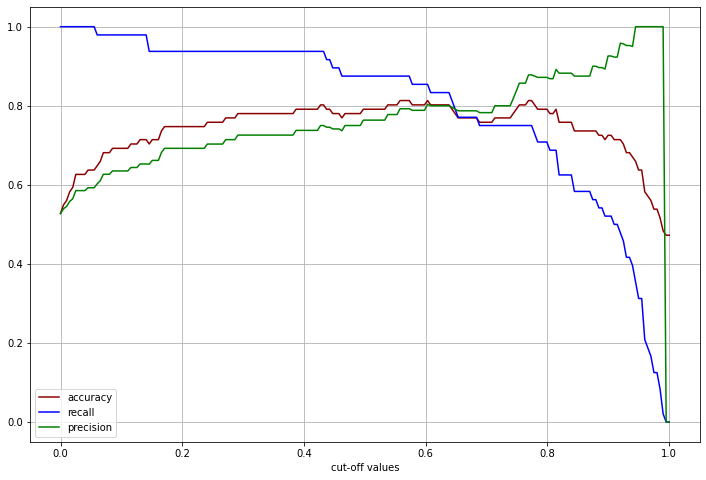

In [14]:
# cut off에 따른 성능 평가 그래프를 그려봅시다.
plt.figure(figsize = (12,8))
plt.plot(cutoff_values, acc, label = 'accuracy', color = 'darkred')
plt.plot(cutoff_values, rec, label = 'recall', color = 'blue')
plt.plot(cutoff_values, prec, label = 'precision', color = 'green')

plt.xlabel('cut-off values')
plt.legend()
plt.grid()
plt.show()

* 위 그래프를 되면, recall과 precision이 서로 trade-off 관계라는 것을 알 수 있습니다.
* Accuracy 최대값과 그때의 cutoff는 어떻게 찾을까요?

In [15]:
# acc의 최대값
max(acc)

0.8131868131868132

In [16]:
# acc가 최대값일 때의 cutoff
print(f'cutoff : {cutoff_values[np.argmax(acc)]}')

cutoff : 0.5577889447236181


* 그래서 위에서 찾은 값을 그래프에 표현해 봅시다.

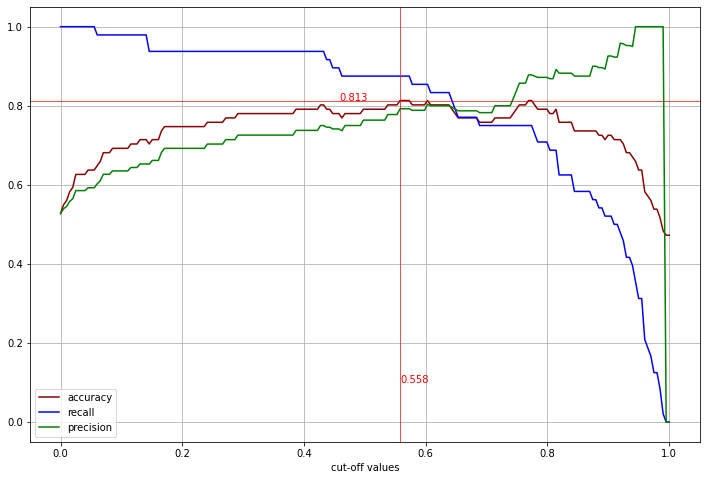

In [17]:
# cut off에 따른 성능 평가 그래프를 그려봅시다.
plt.figure(figsize = (12,8))
plt.plot(cutoff_values, acc, label = 'accuracy', color = 'darkred')
plt.plot(cutoff_values, rec, label = 'recall', color = 'blue')
plt.plot(cutoff_values, prec, label = 'precision', color = 'green')

# Accuracy를 최대화 해주는 cut off를 수평/수직선으로 표시
max_acc_cut = round(cutoff_values[np.argmax(acc)],3)
max_acc = round(max(acc),3)

plt.axvline(max_acc_cut, color = 'r', linewidth = .7)
plt.text(max_acc_cut, .1, max_acc_cut, color = 'r')

plt.axhline(max_acc, color = 'r', linewidth = .7)
plt.text(max_acc_cut -.1, max_acc, max_acc, color = 'r')

plt.xlabel('cut-off values')
plt.legend()
plt.grid()
plt.show()

#### ②  precision - recall curve

* 모델을 평가할 때 cutoff와 상관 없이 전반적인 평가를 하는 방법은, cutoff를 조금씩 조절하면서 그린 성능 curve로 비교하고 평가하는 것입니다.
* 대표적인 두가지가 있습니다.
    * AUROC : 민감도, 1-특이도 곡선 (**실제값 관점에서 모델 성능**)
    * Precision-Recall Curve (**Class 0 혹은 1 관점에서 모델의 성능**)
* 둘 다 cuve 아래 **면적**으로 비교하게 됩니다.
* 여기서는 Precision-Recall Curve 만을 다뤄봅니다.

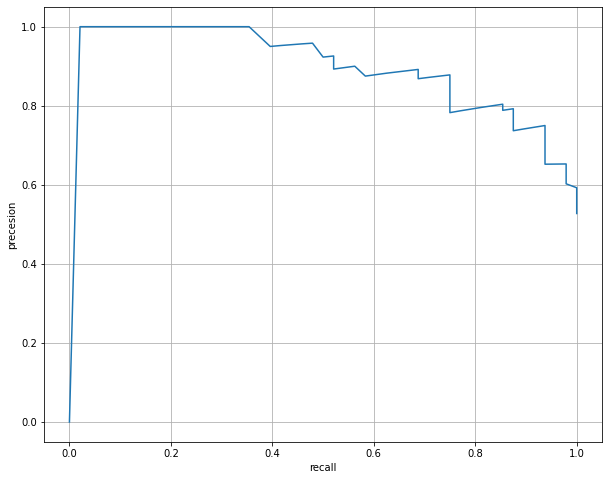

In [18]:
# precision - recall curve
plt.figure(figsize = (10,8))
plt.plot(rec, prec)

plt.xlabel('recall')
plt.ylabel('precesion')

plt.grid()
plt.show()

#### ③ sklearn에서 제공되는 함수들

* precision_recall_curve(실제값, 예측값_확률)

In [19]:
precision, recall, threshold = precision_recall_curve(y_val, result['predicted'])

* plot_precision_recall_curve(모델, x_val, y_val)
    * AP : Curve 아래 면적

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_precision_recall_curve.html

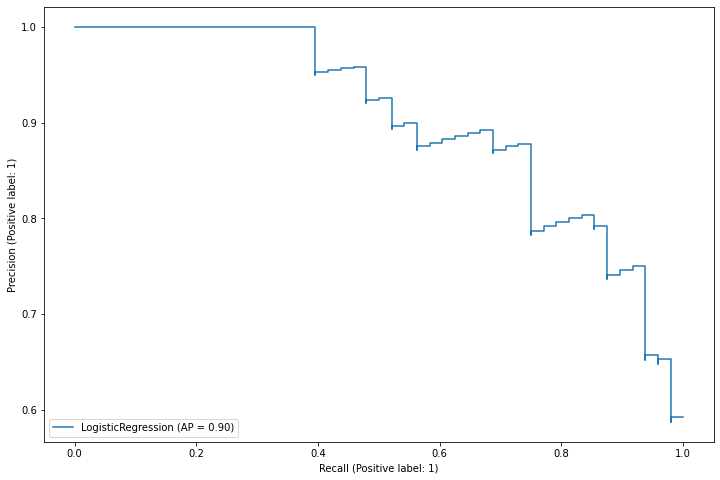

In [20]:
# precision - recall curve
plt.figure(figsize = (12,8))
pr_curve = plot_precision_recall_curve(model, x_val, y_val, ax = plt.gca())
plt.show()

# ax = plt.gca() 옵션은, plt.#### 함수들을 함께 사용할 수 있게 해줍니다.

plot_precision_recall_curve의 결과를 저장하고  
.average_precision 속성을 불러오면, 계산된 아래 면적을 알 수 있습니다.

In [21]:
pr_curve.average_precision

0.9022013399245508

## 5.실습

### 1) 기본실습 

* 다음 알고리즘 중 하나를 선정하여 모델을 생성하시오.
    * Logistinc Regression()
    * Decision Tree(max_depth = 3)
    * Random Forest()

* 모델에 대해서 
    * .predict_proba 로 예측 결과를 저장하시오.
    * cutoff를 0부터 1사이에서 0.01씩 증가시키면서 Accuracy curve를 그려봅시다.
    * Accuracy 최대값, 그때의 cutoff를 찾아 봅시다. 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [25]:
m1 = LogisticRegression()
m1.fit(x_train, y_train)

LogisticRegression()

* .predict_proba로 예측

In [26]:
pred1 = m1.predict_proba(x_val)
pred1 = pred1[:,1]

* 예측결과와 실제 결과를 데이터프레임으로 저장

In [27]:
# 결과를 실제값과 합쳐서 데이터프레임으로 저장합시다.
result = pd.DataFrame({ 'pred1': pred1, 'actual': y_val.values})

* cutoff 조절하며 accuracy score

In [28]:
# 결과를 저장할 빈 리스트
acc = [] 

# 0부터 1까지 cutoff값을 조금씩 증가시키며, 성능 평가결과 저장
cutoff_values = np.linspace(0, 1, 100)

for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    pred_01 = np.where(result['pred1']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc.append(accuracy_score(result['actual'], pred_01))

* Accuracy Curve 그리기

0.5555555555555556 0.8131868131868132


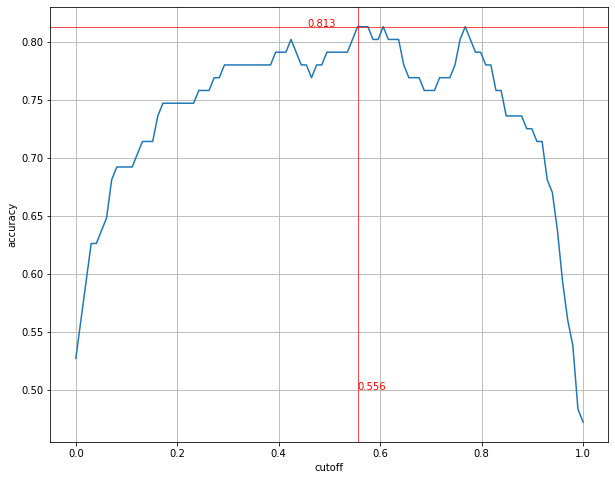

In [29]:
# Accuracy Curve

print(cutoff_values[np.argmax(acc)], max(acc))

plt.figure(figsize = (10,8))
plt.plot(cutoff_values, acc)

max_acc_cut = round(cutoff_values[np.argmax(acc)],3)
max_acc = round(max(acc),3)

plt.axvline(max_acc_cut, color = 'r', linewidth = .7)
plt.text(max_acc_cut, .5, max_acc_cut, color = 'r')

plt.axhline(max_acc, color = 'r', linewidth = .7)
plt.text(max_acc_cut -.1, max_acc, max_acc, color = 'r')


plt.xlabel('cutoff')
plt.ylabel('accuracy')

plt.grid()
plt.show()

### 2) 심화실습1 

* 다음 알고리즘에 대해 각각 모델을 생성하시오.
    * Logistinc Regression()
    * Decision Tree(max_depth = 3)
    * Random Forest()

* 각 모델에 대해서 
    * .predict_proba 로 예측 결과를 저장하시오.
    * cutoff를 0부터 1사이에서 0.01씩 증가시키면서 Accuracy curve를 그려봅시다.
    * Accuracy 최대값, 그때의 cutoff를 찾아 봅시다. 

In [30]:
m1 = LogisticRegression()
m2 = DecisionTreeClassifier(max_depth = 4)
m3 = RandomForestClassifier()

m1.fit(x_train, y_train)
m2.fit(x_train, y_train)
m3.fit(x_train, y_train)

RandomForestClassifier()

* .predict_proba로 예측

In [31]:
pred1 = m1.predict_proba(x_val)
pred2 = m2.predict_proba(x_val)
pred3 = m3.predict_proba(x_val)

pred1 = pred1[:,1]
pred2 = pred2[:,1]
pred3 = pred3[:,1]

* 예측결과와 실제 결과를 데이터프레임으로 저장

In [32]:
# 결과를 실제값과 합쳐서 데이터프레임으로 저장합시다.
result = pd.DataFrame({ 'pred1': pred1, 'pred2': pred2, 'pred3': pred3, 'actual': y_val.values})

* cutoff 조절하며 accuracy score

In [33]:
# 결과를 저장할 빈 리스트
acc1, acc2, acc3 = [],[],[] 

# 0부터 1까지 cutoff값을 조금씩 증가시키며, 성능 평가결과 저장
cutoff_values = np.linspace(0, 1, 100)

for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    pred_01 = np.where(result['pred1']> cutoff, 1, 0)
    pred_02 = np.where(result['pred2']> cutoff, 1, 0)
    pred_03 = np.where(result['pred3']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc1.append(accuracy_score(result['actual'], pred_01))
    acc2.append(accuracy_score(result['actual'], pred_02))
    acc3.append(accuracy_score(result['actual'], pred_03))


In [34]:
# Accuracy Curve 함수를 만들고

def accuracy_plot(accuracy_list, cutoff_list) :
    print(cutoff_values[np.argmax(accuracy_list)], max(accuracy_list))

    plt.figure(figsize = (8,6))
    plt.plot(cutoff_list, accuracy_list)

    max_acc_cut = round(cutoff_list[np.argmax(accuracy_list)],3)
    max_acc = round(max(accuracy_list),3)

    plt.axvline(max_acc_cut, color = 'r', linewidth = .7)
    plt.text(max_acc_cut, .5, max_acc_cut, color = 'r')

    plt.axhline(max_acc, color = 'r', linewidth = .7)
    plt.text(max_acc_cut -.1, max_acc, max_acc, color = 'r')

    plt.xlabel('cutoff')
    plt.ylabel('accuracy')

    plt.grid()
    plt.show()

0.5555555555555556 0.8131868131868132


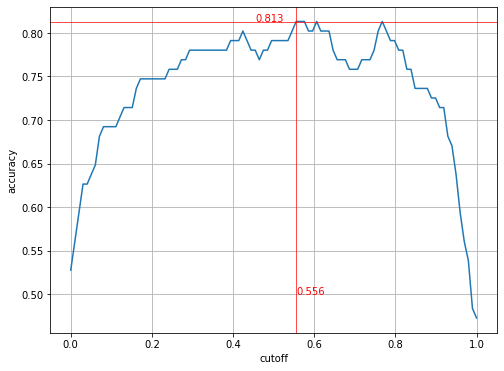

In [35]:
accuracy_plot(acc1, cutoff_values)

0.7171717171717172 0.7692307692307693


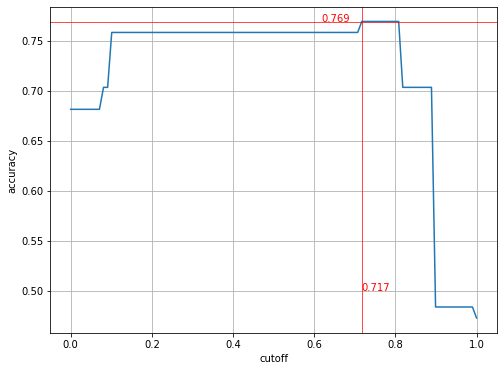

In [36]:
accuracy_plot(acc2, cutoff_values)

0.5252525252525253 0.8241758241758241


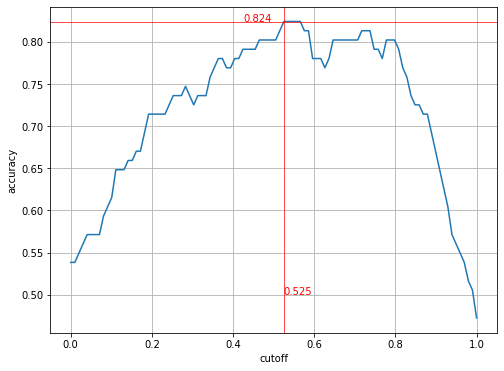

In [37]:
accuracy_plot(acc3, cutoff_values)

### 3) 심화실습2

* 다음 알고리즘으로 모델을 생성하시오.
    * Logistinc Regression()
    * Decision Tree(max_depth = 3)
    * Random Forest()

* 세 모델의 성능비고 : Precision-Recall Curve와 Average Precision로 성능을 비교합시다.


In [38]:
m1 = LogisticRegression()
m2 = DecisionTreeClassifier(max_depth = 4)
m3 = RandomForestClassifier()

m1.fit(x_train, y_train)
m2.fit(x_train, y_train)
m3.fit(x_train, y_train)

RandomForestClassifier()

* .predict_proba로 예측

In [39]:
pred1 = m1.predict_proba(x_val)
pred2 = m2.predict_proba(x_val)
pred3 = m3.predict_proba(x_val)

pred1 = pred1[:,1]
pred2 = pred2[:,1]
pred3 = pred3[:,1]

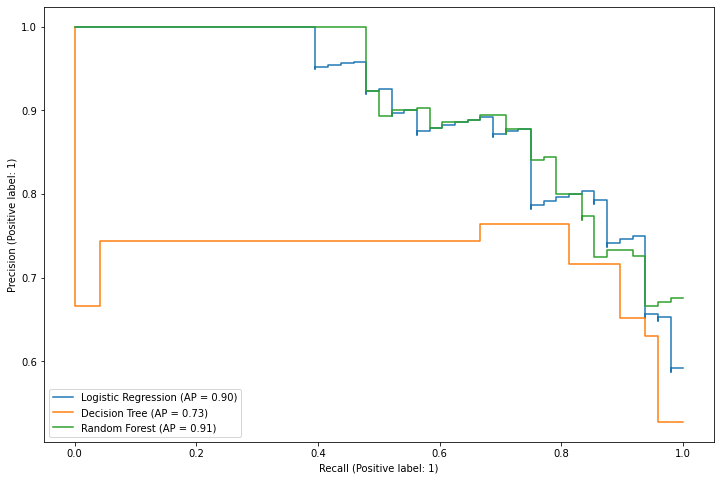

In [40]:
plt.figure(figsize = (12, 8))
ap1 = plot_precision_recall_curve(m1, x_val, y_val, ax = plt.gca(), name = "Logistic Regression")
ap2 = plot_precision_recall_curve(m2, x_val, y_val, ax = plt.gca(), name = "Decision Tree")
ap3 = plot_precision_recall_curve(m3, x_val, y_val, ax = plt.gca(), name = "Random Forest")
plt.show()

In [41]:
print(ap1.average_precision)
print(ap2.average_precision)
print(ap3.average_precision)

0.9022013399245508
0.7264156758156836
0.9081986983985111
